#Installing libraries etc.

In [ ]:
from IPython.display import clear_output
%load_ext autoreload
%autoreload 2
# Install dependencies and 
!pip install albumentations==0.4.6
!pip install pycocotools --quiet

!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils
!python Tutorial-Book-Utils/PL_data_loader.py --data FaceMaskDetection

# Clone TorchVision repo and copy helper files
!git clone https://github.com/pytorch/vision.git
%cd vision
# !git checkout v0.3.0
%cd ..
!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./


# basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd

# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

from torchvision.models.detection.rpn import AnchorGenerator

import torch.nn as nn
import torch.nn.functional as F

# helper libraries
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

!apt-get install python3-openslide
from openslide import open_slide

import plotly.express as px
clear_output()

In [ ]:
from torchvision.models.detection import FasterRCNN
from torch.utils.data import DataLoader, Dataset
import sys
import os
from torchvision.ops import misc as misc_nn_ops

import torch.hub
from functools import partial
from typing import Type, Any, Callable, Union, List, Optional
import torch
import warnings
from typing import Callable, Dict, List, Optional, Union
from torch import nn, Tensor
from torchvision.ops import misc as misc_nn_ops
from torchvision.ops.feature_pyramid_network import ExtraFPNBlock, FeaturePyramidNetwork, LastLevelMaxPool
from collections import OrderedDict
from torchvision.models import resnet 
from torch.hub import load_state_dict_from_url
import enum
from typing import Sequence, TypeVar, Type
from dataclasses import dataclass,fields

T = TypeVar("T", bound=enum.Enum)


class StrEnumMeta(enum.EnumMeta):
    auto = enum.auto

    def from_str(self: Type[T], member: str) -> T:  # type: ignore[misc]
        try:
            return self[member]
        except KeyError:
            # TODO: use `add_suggestion` from torchvision.prototype.utils._internal to improve the error message as
            #  soon as it is migrated.
            raise ValueError(f"Unknown value '{member}' for {self.__name__}.") from None


class StrEnum(enum.Enum, metaclass=StrEnumMeta):
    pass

@dataclass
class Weights:
    """
    This class is used to group important attributes associated with the pre-trained weights.
    Args:
        url (str): The location where we find the weights.
        transforms (Callable): A callable that constructs the preprocessing method (or validation preset transforms)
            needed to use the model. The reason we attach a constructor method rather than an already constructed
            object is because the specific object might have memory and thus we want to delay initialization until
            needed.
        meta (Dict[str, Any]): Stores meta-data related to the weights of the model and its configuration. These can be
            informative attributes (for example the number of parameters/flops, recipe link/methods used in training
            etc), configuration parameters (for example the `num_classes`) needed to construct the model or important
            meta-data (for example the `classes` of a classification model) needed to use the model.
    """

    url: str
    transforms: Callable
    meta: Dict[str, Any]

class WeightsEnum(StrEnum):
    """
    This class is the parent class of all model weights. Each model building method receives an optional `weights`
    parameter with its associated pre-trained weights. It inherits from `Enum` and its values should be of type
    `Weights`.
    Args:
        value (Weights): The data class entry with the weight information.
    """

    def __init__(self, value: Weights):
        self._value_ = value

    @classmethod
    def verify(cls, obj: Any) -> Any:
        if obj is not None:
            if type(obj) is str:
                obj = cls.from_str(obj.replace(cls.__name__ + ".", ""))
            elif not isinstance(obj, cls):
                raise TypeError(
                    f"Invalid Weight class provided; expected {cls.__name__} but received {obj.__class__.__name__}."
                )
        return obj

    def get_state_dict(self, progress: bool) -> OrderedDict:
        return load_state_dict_from_url(self.url, progress=progress)

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}.{self._name_}"

    def __getattr__(self, name):
        # Be able to fetch Weights attributes directly
        for f in fields(Weights):
            if f.name == name:
                return object.__getattribute__(self.value, name)
        return super().__getattr__(name)

class IntermediateLayerGetter(nn.ModuleDict):
    _version = 2
    __annotations__ = {
        "return_layers": Dict[str, str],
    }

    def __init__(self, model: nn.Module, return_layers: Dict[str, str]) -> None:
        if not set(return_layers).issubset([name for name, _ in model.named_children()]):
            raise ValueError("return_layers are not present in model")
        orig_return_layers = return_layers
        return_layers = {str(k): str(v) for k, v in return_layers.items()}
        layers = OrderedDict()
        for name, module in model.named_children():
            layers[name] = module
            if name in return_layers:
                del return_layers[name]
            if not return_layers:
                break

        super().__init__(layers)
        self.return_layers = orig_return_layers

    def forward(self, x):
        out = OrderedDict()
        for name, module in self.items():
            x = module(x)
            if name in self.return_layers:
                out_name = self.return_layers[name]
                out[out_name] = x
        return out

class BackboneWithFPN(nn.Module):
    def __init__(
        self,
        backbone: nn.Module,
        return_layers: Dict[str, str],
        in_channels_list: List[int],
        out_channels: int,
        extra_blocks: Optional[ExtraFPNBlock] = None,
    ) -> None:
        super().__init__()

        if extra_blocks is None:
            extra_blocks = LastLevelMaxPool()

        self.body = IntermediateLayerGetter(backbone, return_layers=return_layers)
        self.fpn = FeaturePyramidNetwork(
            in_channels_list=in_channels_list,
            out_channels=out_channels,
            extra_blocks=extra_blocks,
        )
        self.out_channels = out_channels

    def forward(self, x: Tensor) -> Dict[str, Tensor]:
        x = self.body(x)
        x = self.fpn(x)
        return x

def _resnet_fpn_extractor(
    backbone: resnet.ResNet,
    trainable_layers: int,
    returned_layers: Optional[List[int]] = None,
    extra_blocks: Optional[ExtraFPNBlock] = None,
) -> BackboneWithFPN:

    # select layers that wont be frozen
    if trainable_layers < 0 or trainable_layers > 5:
        raise ValueError(f"Trainable layers should be in the range [0,5], got {trainable_layers}")
    layers_to_train = ["layer4", "layer3", "layer2", "layer1", "conv1"][:trainable_layers]
    if trainable_layers == 5:
        layers_to_train.append("bn1")
    for name, parameter in backbone.named_parameters():
        if all([not name.startswith(layer) for layer in layers_to_train]):
            parameter.requires_grad_(False)

    if extra_blocks is None:
        extra_blocks = LastLevelMaxPool()

    if returned_layers is None:
        returned_layers = [1, 2, 3, 4]
    if min(returned_layers) <= 0 or max(returned_layers) >= 5:
        raise ValueError(f"Each returned layer should be in the range [1,4]. Got {returned_layers}")
    return_layers = {f"layer{k}": str(v) for v, k in enumerate(returned_layers)}

    in_channels_stage2 = backbone.inplanes // 8
    in_channels_list = [in_channels_stage2 * 2 ** (i - 1) for i in returned_layers]
    out_channels = 256
    return BackboneWithFPN(backbone, return_layers, in_channels_list, out_channels, extra_blocks=extra_blocks)

def resnet_fpn_backbone(
    *,
    backbone_name: str,
    weights: Optional[WeightsEnum],
    norm_layer: Callable[..., nn.Module] = misc_nn_ops.FrozenBatchNorm2d,
    trainable_layers: int = 3,
    returned_layers: Optional[List[int]] = None,
    extra_blocks: Optional[ExtraFPNBlock] = None,
) -> BackboneWithFPN:
    
    backbone = resnet.__dict__[backbone_name](weights=weights, norm_layer=norm_layer)
    return _resnet_fpn_extractor(backbone, trainable_layers, returned_layers, extra_blocks)

In [ ]:
# from vision.torchvision.models.detection.backbone_utils import _resnet_fpn_extractor,_validate_trainable_layers

#Setting datapath

In [ ]:
import json
from pathlib import Path

from google.colab import drive
drive.mount('/drive', force_remount=True) 

Mounted at /drive


In [ ]:
hamamatsu_xr ='Hamamatsu XR'
hamamatsu_s360='Hamamatsu S360'
aperio_cs2='Aperio ScanScope CS2'

train_dataset_folder =  aperio_cs2+'/'
test_dataset_folder  =   hamamatsu_s360+'/'

df_train = pd.read_pickle('/drive/MyDrive/CSE499 Project/Patch Datasets/'+train_dataset_folder+'DataFrame.pkl')
df_test  = pd.read_pickle('/drive/MyDrive/CSE499 Project/Patch Datasets/'+test_dataset_folder+'DataFrame.pkl')

#Train and Test Class

In [ ]:
class MitosisImagesDatasetTrain(torch.utils.data.Dataset):
  def __init__(self, files_dir, width, height,transforms=None):
    self.transforms = transforms
    self.files_dir  = files_dir
    self.height     = height
    self.width      = width

    self.imgs = [image for image in sorted(os.listdir(files_dir)) if image[-5:]=='.tiff']
    
    self.classes = [_, 'mitotic figure']

  def __getitem__(self, idx):
    img_name   = self.imgs[idx]
    image_path = os.path.join(self.files_dir, img_name)

    img     = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
    img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)

    img_res /= 255.0
    
    dataframe = df_train[df_train['file_name']==img_name].copy()
    
    boxes = []
    labels = []

    wt = img.shape[1]
    ht = img.shape[0]
    
    for index in dataframe.index:
      labels.append(1)
      
      List = dataframe['box'][index]
      
      scale_x = float(481)/float(self.width)
      scale_y = float(451)/float(self.height)

      xmin = List[0]#/float(scale_x)
      xmax = List[2]#/float(scale_x)
      ymin = List[1]#/float(scale_y)
      ymax = List[3]#/float(scale_y)
      
      # print(xmin,xmax,ymin,ymax)
      # sys.exit()

      xmin_corr = (xmin)
      xmax_corr = (xmax)
      ymin_corr = (ymin)
      ymax_corr = (ymax)
          
      boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
    


    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    labels = torch.as_tensor(labels, dtype=torch.int64)
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    #area = torch.as_tensor(area, dtype=torch.float32)
    iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
    
    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["image_id"] = torch.tensor([idx])
    target["area"] = area
    target["iscrowd"] = iscrowd
    
    if self.transforms:
      sample = self.transforms(image = img_res,
                                bboxes = target['boxes'],
                                labels = labels)
      img_res = sample['image']
      target['boxes'] = torch.Tensor(sample['bboxes'])

    return img_res, target
    
  def __len__(self):
    return len(self.imgs)

class MitosisImagesDatasetTest(torch.utils.data.Dataset):
  def __init__(self, files_dir, width, height,transforms=None):
    self.transforms = transforms
    self.files_dir  = files_dir
    self.height     = height
    self.width      = width

    self.imgs = [image for image in sorted(os.listdir(files_dir)) if image[-5:]=='.tiff']
    
    self.classes = [_, 'mitotic figure']

  def __getitem__(self, idx):
    img_name   = self.imgs[idx]
    image_path = os.path.join(self.files_dir, img_name)

    img     = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
    img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)

    img_res /= 255.0
    
    dataframe = df_test[df_test['file_name']==img_name].copy()
    
    boxes = []
    labels = []

    wt = img.shape[1]
    ht = img.shape[0]
    
    for index in dataframe.index:
      labels.append(1)
      
      List = dataframe['box'][index]
      
      scale_x = float(481)/float(self.width)
      scale_y = float(451)/float(self.height)

      xmin = List[0]#/float(scale_x)
      xmax = List[2]#/float(scale_x)
      ymin = List[1]#/float(scale_y)
      ymax = List[3]#/float(scale_y)

      

      xmin_corr = (xmin)
      xmax_corr = (xmax)
      ymin_corr = (ymin)
      ymax_corr = (ymax)
          
      boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
    


    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    labels = torch.as_tensor(labels, dtype=torch.int64)
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    #area = torch.as_tensor(area, dtype=torch.float32)
    iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
    
    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["image_id"] = torch.tensor([idx])
    target["area"] = area
    target["iscrowd"] = iscrowd
    
    if self.transforms:
      sample = self.transforms(image = img_res,
                                bboxes = target['boxes'],
                                labels = labels)
      img_res = sample['image']
      target['boxes'] = torch.Tensor(sample['bboxes'])

    return img_res, target
    
  def __len__(self):
    return len(self.imgs)

#Plotting and setting training data

In [ ]:
# Function to visualize bounding boxes in the image
def plot_img_bbox(img, target):
  # plot the image and bboxes
  # Bounding boxes are defined as follows: x-min y-min width height
  fig, a = plt.subplots(1,1)
  fig.set_size_inches(5,5)
  a.imshow(img)
  for box in (target['boxes']):
    x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
    rect = patches.Rectangle(
      (x, y),
      width, height,
      linewidth = 2,
      edgecolor = 'r',
      facecolor = 'none'
    )
    # Draw the bounding box on top of the image
    a.add_patch(rect)
  plt.show()

  # Send train=True for training transforms and False for val/test transforms
def get_transform(train):
  if train:
    return A.Compose(
      [
        A.HorizontalFlip(0.5),
        # ToTensorV2 converts image to pytorch tensor without div by 255
        ToTensorV2(p=1.0) 
      ],
      bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
    )
  else:
    return A.Compose(
      [ToTensorV2(p=1.0)],
      bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
    )

/drive/MyDrive/CSE499 Project/Patch Datasets/Aperio ScanScope CS2/
/drive/MyDrive/CSE499 Project/Patch Datasets/Hamamatsu S360/
(451, 481, 3)


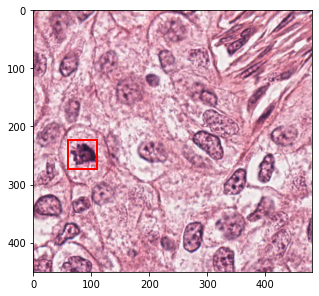

In [ ]:
train_dir = '/drive/MyDrive/CSE499 Project/Patch Datasets/'+train_dataset_folder
test_dir = '/drive/MyDrive/CSE499 Project/Patch Datasets/'+test_dataset_folder

print(train_dir)
print(test_dir)

dataset =      MitosisImagesDatasetTrain(train_dir, 481, 451)
dataset_test = MitosisImagesDatasetTest(test_dir, 481,451)

# plotting the image with bboxes. Feel free to change the index
img, target = dataset[100]
print(img.shape)
plot_img_bbox(img, target)

In [ ]:
train_dataset =      MitosisImagesDatasetTrain(train_dir, 481, 451,transforms=get_transform(train=True))

def collate_fn(batch):
    return tuple(zip(*batch))

train_data_loader  = DataLoader(train_dataset,batch_size=8,shuffle=True,num_workers=4,collate_fn=utils.collate_fn)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


#Training part

In [ ]:
!git clone https://github.com/ZjjConan/SimAM.git
%cd /content/SimAM
from networks.imagenet import create_net
import argparse

Cloning into 'SimAM'...
remote: Enumerating objects: 176, done.
remote: Total 176 (delta 0), reused 0 (delta 0), pack-reused 176
Receiving objects: 100% (176/176), 74.68 MiB | 25.14 MiB/s, done.
Resolving deltas: 100% (47/47), done.
/content/SimAM


In [ ]:
import sys
sys.argv=['']
del sys

In [ ]:
parser = argparse.ArgumentParser(description='PyTorch ImageNet Training')

parser.add_argument("--attention_type", type=str, default="simam",
                    help="attention type (possible choices none | se | cbam | simam)")

parser.add_argument("--attention_param", type=float, default=4,
                    help="attention parameter (reduction factor in se and cbam, e_lambda in simam)")

parser.add_argument('-a', '--arch', metavar='ARCH', default='resnet50',
                    help='model architecture (default: resnet18)')


args=parser.parse_args()
backbone = create_net(args)

In [ ]:
num_classes=2
backbone = _resnet_fpn_extractor(backbone,trainable_layers=3)
model = FasterRCNN(backbone,num_classes=num_classes)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model = model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
num_epochs = 50

In [ ]:
# print("ResNet50")
# print(vanillaResnet50.layer1)
# print(" ")
# print("ResNet50 with SE")
# print(resnet50_SE.layer1)

In [ ]:
print(train_dir)
print(test_dir)

/drive/MyDrive/CSE499 Project/Patch Datasets/Aperio ScanScope CS2/
/drive/MyDrive/CSE499 Project/Patch Datasets/Hamamatsu S360/


In [ ]:
# with torch.no_grad():
#     torch.cuda.empty_cache()

In [ ]:
!pip3 install mlnotify

In [ ]:
import mlnotify

In [ ]:
# %cd '/drive/MyDrive/CSE499 Project/modelSaves/Attention Mechanism/SENet/model3'
mlnotify.start()
for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=10)
    #save the model
    # torch.save(model.state_dict(), 'model.pth')
    # torch.save({
    # 'epoch':epoch+1,
    # 'model_state_dict':model.state_dict(),
    # 'optimizer_state_dict':optimizer.state_dict(),
    # },'ckpt.pth')
    # update the learning rate
    lr_scheduler.step()

mlnotify.end()

                                     
                                     
    █▀▀▀▀▀█ ▄█ ▄▄█▄▄▄ █▀█ █▀▀▀▀▀█    
    █ ███ █ ▄█▀█ ▄▀▄▀▄▄▄  █ ███ █    
    █ ▀▀▀ █ ▄ █ ▀ ▀▄▀█▀▀▀ █ ▀▀▀ █    
    ▀▀▀▀▀▀▀ ▀ ▀ █ ▀ █ █▄▀ ▀▀▀▀▀▀▀    
    ▀█▀██▄▀▀▀█▀ ▀▀▄ ▄▀▄▄█▀▄█▄▀ ▀▄    
    █ ▀ ▄█▀ ▀█▄█▀▀▄█▀▀▀▄█▄ █ ▄ ▄     
    ██▀▄█▄▀███▄▀▄▀▄ ▄█▄█▄▄▄▄▄▀▀ ▄    
    █▀▀   ▀▄▀█▄ ▄▀▀▀▄▀   ▀▀▄ ▀▀▄     
    ▄ ▀▀█ ▀▀▀█▀ ▀▀▄ ▄█▄▄█▄▄▄▄▀█ ▄    
    █ ▀  ▄▀▀▀█▄█▀▀██▀   ▀▄▄▄▀ ▀▄     
    ▀  ▀▀ ▀▀▄▀ ▀▄█▄ ▄██ █▀▀▀█▄███    
    █▀▀▀▀▀█ ▀█▀ ▄ ▄█▀▀ ██ ▀ █▀▀ ▄    
    █ ███ █ █ █ ▀▀▄▀▄▀  █▀▀▀▀▄███    
    █ ▀▀▀ █ █▄ █▀ █▀  ▄▀█▄████▀█     
    ▀▀▀▀▀▀▀ ▀▀ ▀▀  ▀▀▀     ▀  ▀      
                                     
                                     
https://mlnotify.aporia.com/training/036795

Scan the QR code or enter the url to get a notification when your training is done


Epoch: [0]  [  0/279]  eta: 0:51:40  lr: 0.000000  loss: 1.1152 (1.1152)  loss_classifier: 0.3376 (0.3376)  loss_box_reg: 0.0221 (0.0221)  loss_obje

Saving Model

In [ ]:
# %cd '/drive/MyDrive/CSE499 Project/modelSaves/Attention Mechanism/SENet/model3'

torch.save(model.state_dict(), 'model.pth')

torch.save({
'epoch':num_epochs,
'model_state_dict':model.state_dict(),
'optimizer_state_dict':optimizer.state_dict(),
},'ckpt.pth')

[Errno 2] No such file or directory: '/drive/MyDrive/CSE499 Project/modelSaves/Attention Mechanism/SENet/model3'
/content/Tutorial-Book-Utils


Loading model

In [ ]:
# %cd '/drive/MyDrive/CSE499 Project/modelSaves/Attention Mechanism/Channel/SENet/model3'
model.load_state_dict(torch.load('./model.pth'))
model = model.to(device)

/drive/.shortcut-targets-by-id/1M-kTVs7g43FucvCjcPvKwiR8r1e1qtHe/CSE499_Project/modelSaves/Attention Mechanism/Channel/SENet/model3


#Testing

In [ ]:
test_dataset = MitosisImagesDatasetTest(test_dir, 481, 451,transforms=get_transform(train=False))

torch.manual_seed(1)
indices = torch.randperm(len(dataset_test)).tolist()

test_split = 0.2
tsize = int(len(test_dataset)*test_split)

test_dataset = torch.utils.data.Subset(test_dataset, indices[-tsize:])

test_data_loader = torch.utils.data.DataLoader(
  test_dataset,
  batch_size=10,
  shuffle=False,
  num_workers=4,
  collate_fn=utils.collate_fn,
)
test_dir

'/drive/MyDrive/CSE499 Project/Patch Datasets/Hamamatsu S360/'

In [ ]:
def apply_nms(orig_prediction, iou_thresh=0.3):
  keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
  
  final_prediction = orig_prediction
  final_prediction['boxes'] = final_prediction['boxes'][keep]
  final_prediction['scores'] = final_prediction['scores'][keep]
  final_prediction['labels'] = final_prediction['labels'][keep]
  
  return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
  return torchtrans.ToPILImage()(img).convert('RGB')

In [ ]:
test_dataset = MitosisImagesDatasetTest(test_dir, 481, 451, transforms = get_transform(train=False))
dataset      = MitosisImagesDatasetTest(test_dir, 481, 451)
test_dir

'/drive/MyDrive/CSE499 Project/Patch Datasets/Hamamatsu S360/'

Predicted labels

MODEL OUTPUT



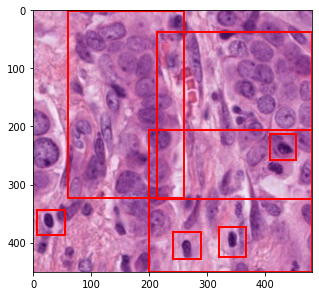

In [ ]:
# pick one image from the test set
INDEX_PICK = 53
model=model.to('cpu')
img, target = test_dataset[INDEX_PICK]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
  img = img.to('cpu')
  prediction = model([img])[0]

print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction,iou_thresh=0.3)

plot_img_bbox(torch_to_pil(img), nms_prediction)

Ground Truth labels

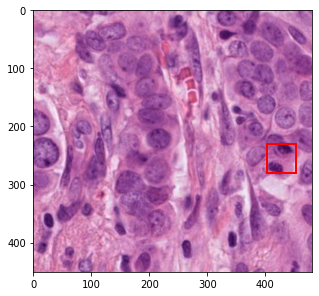

In [ ]:
img, target = dataset[INDEX_PICK]
plot_img_bbox(img, target)

In [ ]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : 
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

In [ ]:
model=model.to(device)

In [ ]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_data_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)
    #annot = [{k: v.to(device) for k, v in t.items()} for t in annot]

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(model, im, 0.3)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)

100%|██████████| 38/38 [01:02<00:00,  1.64s/it]


In [ ]:
%cd /content/Tutorial-Book-Utils
import utils_ObjectDetection as utils2

/content/Tutorial-Book-Utils


Trained on Dataset X, Tested on Dataset Y

In [ ]:
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils2.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.3) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]
precision, recall, AP, f1, ap_class = utils2.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
# print(f'AP : {AP}')

mAP : 0.01803810882022755


In [ ]:
print('precision: ',precision)
print('recall: ',recall)
print('AP: ',AP)
print('f1: ',f1)
print('ap_class: ',ap_class)

precision:  tensor([0.3404])
recall:  tensor([0.0386])
AP:  tensor([0.0180], dtype=torch.float64)
f1:  tensor([0.0693])
ap_class:  tensor([1])


In [ ]:
print(train_dir)
print(test_dir)

/drive/MyDrive/CSE499 Project/Patch Datasets/Aperio ScanScope CS2/
/drive/MyDrive/CSE499 Project/Patch Datasets/Hamamatsu S360/
